Recieving Signal
================

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)
d = 0.5 # half wavelength spacing
Nr = 8
theta_degrees = 50 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(s) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j         -0.74183541-0.67058201j  0.10063955+0.99492295j
  0.59251945-0.80555614j -0.97974336+0.20025719j  0.86109718+0.5084404j
 -0.2978414 -0.95461537j -0.41919859+0.90789456j]


To apply the steering vector we have to do a matrix multiplication of s and tx, so first let’s convert both to 2D, using the approach we discussed earlier when we reviewed doing matrix math in Python. We’ll start off by making both into row vectors using ourarray.reshape(-1,1). We then perform the matrix multiply, indicated by the @ symbol. We also have to convert tx from a row vector to a column vector using a transpose operation (picture it rotating 90 degrees) so that the matrix multiply inner dimensions match.

In [19]:
s = s.reshape(-1,1) # make s a column vector
print(s.shape) # 3x1
tx = tx.reshape(1,-1) # make tx a row vector
print(tx.shape) # 1x10000

X = s @ tx # Simulate the received signal X through a matrix multiply
print(X.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension

(8, 1)
(1, 10000)
(8, 10000)


At this point X is a 2D array, size 3 x 10000 because we have three array elements and 10000 samples simulated. We use uppercase X to represent the fact that it’s multiple received signals combined (stacked) together. We can pull out each individual signal and plot the first 200 samples; below we’ll plot the real part only, but there’s also an imaginary part, like any baseband signal. One annoying part of matrix math in Python is needing to add the .squeeze(), which removes all dimensions with length 1, to get it back to a normal 1D NumPy array that plotting and other operations expects.

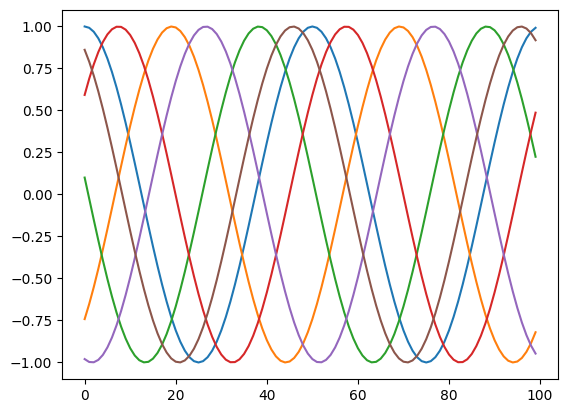

In [20]:
plt.plot(np.asarray(X[0,:]).squeeze().real[0:100]) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(X[1,:]).squeeze().real[0:100])
plt.plot(np.asarray(X[2,:]).squeeze().real[0:100])
plt.plot(np.asarray(X[3,:]).squeeze().real[0:100])
plt.plot(np.asarray(X[4,:]).squeeze().real[0:100])
plt.plot(np.asarray(X[5,:]).squeeze().real[0:100])
plt.show()

Note the phase shifts between elements like we expect to happen (unless the signal arrives at boresight in which case it will reach all elements at the same time and there won’t be a shift, set theta to 0 to see). Element 0 appears to arrive first, with the others slightly delayed. Try adjusting the angle and see what happens.

As one final step, let’s add noise to this received signal, as every signal we will deal with has some amount of noise. We want to apply the noise after the steering vector is applied, because each element experiences an independent noise signal (we can do this because AWGN with a phase shift applied is still AWGN):

In [21]:
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
X = X + 0.5*n # X and n are both 3x10000

We’ll start with the “conventional” beamforming approach, a.k.a. delay-and-sum beamforming. Our weights vector w needs to be a 1D array for a uniform linear array, in our example of three elements, w is a 3x1 array of complex weights. With conventional beamforming we leave the magnitude of the weights at 1, and adjust the phases so that the signal constructively adds up in the direction of our desired signal, which we will refer to as $\theta$. It turns out that this is the exact same math we did above, i.e., our weights are our steering vector!
<br /> <p align=center>
 $w_{conv} = e^{-2j \pi d k \sin(\theta)}$

In [22]:
w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Conventional, aka delay-and-sum, beamformer
X_weighted = w.conj().T @ X # example of applying the weights to the received signal (i.e., perform the beamforming)
print(X_weighted.shape) # 1x10000

(10000,)


49.9099099099099


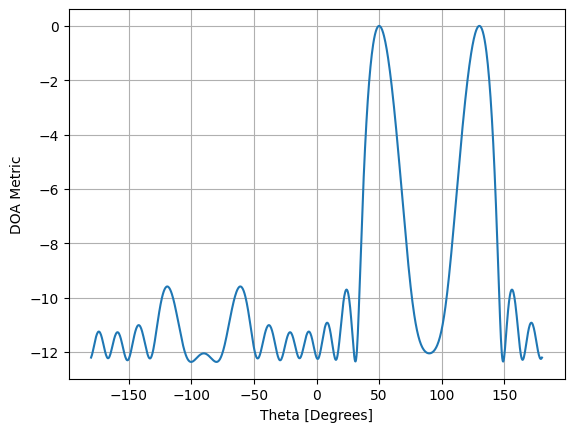

In [23]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # 1000 different thetas between -180 and +180 degrees
results = []
for theta_i in theta_scan:
   w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Conventional, aka delay-and-sum, beamformer
   X_weighted = w.conj().T @ X # apply our weights. remember X is 3x10000
   results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) # normalize (optional)

# print angle that gave us the max value
print(theta_scan[np.argmax(results)] * 180 / np.pi) # 19.99999999999998

plt.plot(theta_scan*180/np.pi, results) # lets plot angle in degrees
plt.xlabel("Theta [Degrees]")
plt.ylabel("DOA Metric")
plt.grid()
plt.show()

Polar Plot

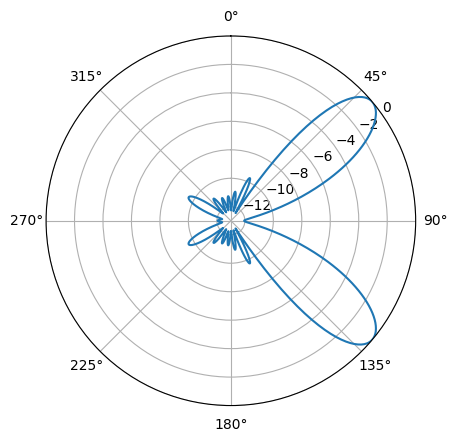

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()